In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import json
import numpy as np
import pandas as pd

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
df = loader.get_df(all_files=True)
df = df[df["Origin"] == "BOS"]
df = df[
    [
        "DistanceGroup",
        "DayofMonth",
        "Month",
        "Year",
        "Duplicate",
        "ArrDel15",
        "DistanceGroup",
        "WeatherDelay",
        "NASDelay",
        "SecurityDelay",
        "Operating_Airline",
        "Dest",
    ]
]
df = builder.encodeFrame(df)

delay_df = df[df["ArrDel15"] > 0.5].sample(n=20000)
on_time_df = df[df["ArrDel15"] <= 0.5].sample(n=80000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=["ArrDel15"])
y = sample_df[["ArrDel15"]]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=150
)
print(sample_df.shape)

(100000, 122)


In [10]:
svm_pipeline = models.get_pipeline(ModelENUM.SVM)
param_grid = [

    # models.get_svm_param(gamma=['auto', 'scale'], c_list=[1, 10], coef0=[0, 1, 2], degree=[2,3], kernel=['linear', 'poly'], max_iter=[5000], cache_size=[8000])
    models.get_svm_param(
        gamma=["scale"],
        c_list=[.1, 1, 10],
        coef0=[0, 1],
        kernel=["linear", "poly", "rbf"],
        max_iter=[1500],
    )
    # models.get_svm_param(gamma=[2, 3, 4, 'scale', 'auto'], c_list=[1e-2, 1e-1, 1e1, 1e2], coef0=[0, 1, 2], kernel=['linear', 'poly', 'rbf'])
    # models.get_svm_param(gamma=[2], c_list=[1e-2], coef0=[1], kernel=['linear'])
]
grid_search = models.get_grid_search_cv(
    pipeline=svm_pipeline, param_grid=param_grid, cv=3, n_jobs=15
)

In [11]:
with joblib.parallel_backend('threading', n_jobs=15):
    svm_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[CV 2/3; 1/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[CV 3/3; 1/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[CV 1/3; 2/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[CV 2/3; 2/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -297.211505, rho = -0.144083
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.[CV 3/3; 4/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.380 total time=11.7min
[CV 1/3; 6/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 2/3; 4/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.369 total time=11.7min
[CV 2/3; 6/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.797415, rho = -0.020708
nS

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.Line search fails in two-class probability estimates
[CV 2/3; 5/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.387 total time=12.3min
[CV 3/3; 6/18] START svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -294.299776, rho = -0.298531
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.849357, rho = -0.026967
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.325170, rho = 0.018304
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 1/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.423 total time=12.8min
[CV 1/3; 7/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM][CV 2/3; 2/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.356 total time=12.8min
[CV 2/3; 7/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.816053, rho = 0.117914
nSV =

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.221043, rho = 0.015704
nSV = 3000, nBSV = 3000
Total nSV = 3000
[CV 2/3; 1/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.369 total time=13.2min
[CV 3/3; 7/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].....Line search fails in two-class probability estimates
..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.721621, rho = -0.030823
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.400601, rho = -0.004444
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.[CV 2/3; 3/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.423 total time=13.8min
[CV 1/3; 8/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -296.233463, rho = -0.156166
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.814627, rho = -0.023243
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.319491, rho = 0.069419
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.700231, rho = -0.032117
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.336482, rho = 0.029564
nSV = 3000, nBSV = 3000
Total nSV = 3000
[CV 3/3; 1/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.380 total time=13.9min
[CV 2/3; 8/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LibSVM].WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -294.299776, rho = -0.298531
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 2/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.337 total time=14.0min
[CV 3/3; 8/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 3/3; 2/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.340 total time=14.0min
[CV 1/3; 9/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 1/3; 4/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linea

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2997.369147, rho = -0.717482
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.244112, rho = 0.007315
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2994.303647, rho = -0.996852
nSV = 3000, nBSV = 2998
Total nSV = 3000
[CV 3/3; 5/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.421 total time=14.8min
[CV 3/3; 9/18] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM][CV 1/3; 3/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.435 total time=14.9min
[CV 1/3; 10/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2992.680410, rho = -0.542410
nSV = 3000, nBSV = 2998
Total nSV = 3000
[CV 1/3; 5/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.344 total time=15.1min
[CV 2/3; 10/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].......WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.803881, rho = -0.025431
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2968.481417, rho = 1.222197
nSV = 3000, nBSV = 3000
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2975.822335, rho = 0

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2990.628752, rho = -0.207148
nSV = 3000, nBSV = 3000
Total nSV = 3000
[CV 3/3; 3/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.271 total time=16.8min
[CV 3/3; 10/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.865824, rho = -0.027733
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2993.195863, rho = -1.585137
nSV = 3000, nBSV = 2998
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2972.509408, rho = -1.4

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2971.481956, rho = 1.180477
nSV = 3000, nBSV = 2998
Total nSV = 3000
.[CV 2/3; 10/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.402 total time=11.6min
[CV 1/3; 11/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2793.811348, rho = -1.136591
nSV = 2996, nBSV = 2988
Total nSV = 2996


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -298.244112, rho = 0.007315
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.830462, rho = -0.029944
nSV = 3000, nBSV = 3000
Total nSV = 3000
[CV 3/3; 7/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.350 total time=13.6min
[CV 2/3; 11/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 1/3; 6/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.435 total time=15.2min
[CV 3/3; 11/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2995.428647, rho = -1.849547
nSV = 3000, nBSV = 3000
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2842.207262, rho = -1.483365
nSV = 2993, nBSV = 2991
Total nSV = 2993


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


..[CV 2/3; 7/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.402 total time=15.4min
[CV 1/3; 12/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM][CV 1/3; 7/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.397 total time=15.5min
[CV 2/3; 12/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2854.211091, rho = 0.801468
nSV

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 8/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.337 total time=15.1min
[CV 3/3; 12/18] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2852.426220, rho = 0.343815
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 8/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.350 total time=15.1min
[CV 1/3; 13/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2897.556106, rho = 0.114941
nSV = 2997, nBSV = 2985
Total nSV = 2997
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2993.103283, rho = -2.066915
nSV = 3000, nBSV = 2998
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2894.498242, rho = 1.180342
nSV = 2993, nBSV = 2985
Total nSV = 2993
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2904.138043, rho = 0.392641

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2982.203837, rho = -0.214944
nSV = 3000, nBSV = 3000
Total nSV = 3000
.[CV 2/3; 6/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.423 total time=17.9min
[CV 2/3; 13/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2868.199436, rho = -0.149208
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2858.755645, rho = 0.350212
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 8/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.347 total time=16.0min
[CV 3/3; 13/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 2/3; 9/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.348 total time=16.1min
[CV 1/3; 14/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2842.207262, rho = -1.483365
nSV = 2

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -299.146784, rho = -0.002189
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 10/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.397 total time=15.4min
[CV 2/3; 14/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM].[CV 3/3; 6/18] END svm__C=0.1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.271 total time=18.2min
[CV 3/3; 14/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
.[LibSVM]..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2982.942097, rho = -0.173268
n

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


..[CV 3/3; 10/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.350 total time=14.4min
[CV 1/3; 15/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2987.532978, rho = -0.190281
nSV = 3000, nBSV = 3000
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28617.236389, rho = -5.662054
nSV = 2957, nBSV = 2778
Total nSV = 2957
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2963.706534, rho = -0.327260
nSV = 3000, nBSV = 3000
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2940.338134, rho = 0.

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27812.430917, rho = 2.235943
nSV = 2974, nBSV = 2894
Total nSV = 2974
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28768.247040, rho = -5.526189
nSV = 2961, nBSV = 2820
Total nSV = 2961
[CV 1/3; 9/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.396 total time=18.9min
[CV 2/3; 15/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27512.855957, rho = 3.610843
nSV = 2965, nBSV = 2858
Total nSV = 2965
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2913.015667, rho = -0.064629
n

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27824.605368, rho = 1.798024
nSV = 2980, nBSV = 2887
Total nSV = 2980
..[CV 3/3; 9/18] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.410 total time=18.3min
[CV 3/3; 15/18] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29164.053095, rho = -1.423110
nSV = 3000, nBSV = 2996
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28576.301276, rho = -5.421085
nSV = 2935, nBSV = 2793
Total nSV = 2935
...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2991.627752, rho = -0

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 11/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.382 total time=15.6min
[CV 1/3; 16/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28109.841975, rho = -6.100369
nSV = 2966, nBSV = 2849
Total nSV = 2966
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28936.594099, rho = -1.471594
nSV = 2999, nBSV = 2997
Total nSV = 2999
.....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2633.128869, rho = -0.078755
nSV = 2909, nBSV = 2856
Total nSV = 2909


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Line search fails in two-class probability estimates
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28351.446055, rho = 2.437912
nSV = 2989, nBSV = 2943
Total nSV = 2989
obj = -21904.430192, rho = -4.342728
nSV = 2709, nBSV = 1902
Total nSV = 2709


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 11/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.394 total time=16.9min
[CV 2/3; 16/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[CV 2/3; 13/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.373 total time=14.1min
[CV 3/3; 16/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM][LibSVM]...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -20066.975589, rho = -8.017

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 13/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.359 total time=14.9min
[CV 1/3; 17/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2598.237690, rho = -0.549526
nSV = 2878, nBSV = 2755
Total nSV = 2878


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28495.116418, rho = 2.506121
nSV = 2991, nBSV = 2934
Total nSV = 2991
[CV 1/3; 11/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.343 total time=17.5min
[CV 2/3; 17/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2965.160859, rho = -0.297629
nSV = 3000, nBSV = 3000
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27646.827740, rho = 1.915357
nSV = 2954, nBSV = 2825
Total nSV = 2954
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2987.212473, rho = -0.20306

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 13/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.437 total time=14.8min
[CV 3/3; 17/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29053.096771, rho = -1.196391
nSV = 2997, nBSV = 2993
Total nSV = 2997
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28719.234932, rho = -1.289587
nSV = 2993, nBSV = 2985
Total nSV = 2993
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -23195.889660, rho = 1.337443
nSV = 2641, nBSV = 2297
Total nSV = 2641


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 14/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.336 total time=14.7min
[CV 1/3; 18/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28931.947007, rho = -1.125370
nSV = 2994, nBSV = 2983
Total nSV = 2994
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22504.726056, rho = 0.009663
nSV = 2721, nBSV = 2065
Total nSV = 2721
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2972.706641, rho = -0.145251
nSV = 3000, nBSV = 3000
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28127.865342, rho = -9.2

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.[CV 1/3; 14/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.411 total time=15.9min
[CV 2/3; 18/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -23392.925712, rho = -0.554570
nSV = 2689, nBSV = 2409
Total nSV = 2689


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 14/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.361 total time=16.0min
[CV 3/3; 18/18] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -20603.629367, rho = 2.230977
nSV = 2603, nBSV = 1849
Total nSV = 2603
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2860.813597, rho = -0.064764
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27973.455502, rho = -8.522285
nSV = 2935, nBSV = 2773
Total nSV = 2935
.[CV 1/3; 12/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.396 total time=18.4min
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2913.015667, rho = -0.064629
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


..[CV 3/3; 12/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.410 total time=18.0min
.....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22336.987446, rho = 2.900675
nSV = 2717, nBSV = 2082
Total nSV = 2717
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24115.449156, rho = -1.351830
nSV = 2738, nBSV = 2540
Total nSV = 2738
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28886.771751, rho = -1.512316
nSV = 2996, nBSV = 2979
Total nSV = 2996


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22294.111434, rho = -0.132916
nSV = 2740, nBSV = 2088
Total nSV = 2740
[CV 1/3; 15/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.418 total time=16.3min
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28740.862838, rho = -9.520694
nSV = 2957, nBSV = 2810
Total nSV = 2957
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29231.530050, rho = -0.416752
nSV = 2998, nBSV = 2993
Total nSV = 2998
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22617.745784, rho = 1.540154
nSV = 2693, nBSV = 2134
Total nSV = 2693
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -2868.199436, rho = -0.149208
nSV = 3000, nBSV = 3000
Total nSV = 3000


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29333.472757, rho = -1.033713
nSV = 3000, nBSV = 2994
Total nSV = 3000
.[CV 2/3; 12/18] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.348 total time=19.6min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28131.267266, rho = -5.835231
nSV = 2946, nBSV = 2778
Total nSV = 2946
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28851.352376, rho = -2.048787
nSV = 2997, nBSV = 2987
Total nSV = 2997
...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28770.335004, rho = -1.273891
nSV = 2998, nBSV = 2972
Total nSV = 2998
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -23244.063654, rho = 1.502612
nSV = 2782, nBSV = 2156
Total nSV = 2782
.WARN: lib

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


..[CV 2/3; 15/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.410 total time=16.7min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28832.761324, rho = -1.050351
nSV = 2997, nBSV = 2979
Total nSV = 2997
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -23052.374418, rho = 0.699705
nSV = 2731, nBSV = 2161
Total nSV = 2731
..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28303.816445, rho = -9.750698
nSV = 2959, nBSV = 2806
Total nSV = 2959
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24432.936528, rho = -0.821142
nSV = 2702, nBSV = 2501
Total nSV = 2702


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22764.089490, rho = -0.839929
nSV = 2713, nBSV = 2167
Total nSV = 2713
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28843.411482, rho = -1.215375
nSV = 3000, nBSV = 2996
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -23230.938118, rho = 1.288291
nSV = 2753, nBSV = 2195
Total nSV = 2753
[CV 3/3; 15/18] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.388 total time=17.0min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29052.211108, rho = -0.757618
nSV = 2991, nBSV = 2983
Total nSV = 2991
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28572.485155, rho = -6.615488
nSV = 2943, nBSV = 2815
Total nSV = 2943
WARN: libsv

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 17/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.445 total time= 7.5min
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -27793.527126, rho = -9.121588
nSV = 2963, nBSV = 2836
Total nSV = 2963
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29052.452350, rho = -1.802118
nSV = 2993, nBSV = 2982
Total nSV = 2993
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28663.589331, rho = -8.270924
nSV = 2953, nBSV = 2819
Total nSV = 2953
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -22777.384395, rho = 0.524457
nSV = 2769, nBSV = 2166
Total nSV = 2769
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28907.177039, rho = -0.720286
nSV = 2989, nBSV = 2981
Total nSV = 2989
.WARN: libs

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 17/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.387 total time= 7.8min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28396.508594, rho = -0.377869
nSV = 2982, nBSV = 2959
Total nSV = 2982
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -14410.679052, rho = -0.975693
nSV = 2114, nBSV = 1121
Total nSV = 2114


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 17/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=poly, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.415 total time= 7.5min
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -21904.430192, rho = -4.342728
nSV = 2709, nBSV = 1902
Total nSV = 2709


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 16/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.373 total time= 8.7min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -20066.975589, rho = -8.017935
nSV = 2533, nBSV = 1678
Total nSV = 2533
.

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28437.896979, rho = -4.401061
nSV = 2954, nBSV = 2792
Total nSV = 2954
[CV 1/3; 16/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.359 total time=10.0min
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28702.957818, rho = -1.471736
nSV = 2998, nBSV = 2982
Total nSV = 2998
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -28263.201961, rho = -1.071366
nSV = 2989, nBSV = 2956
Total nSV = 2989
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29198.552835, rho = -1.143186
nSV = 3000, nBSV = 2996
Total nSV = 3000
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -20928.717857, rho = -5.658390
nSV = 2569, nBSV = 1833
Total nSV = 2569


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 16/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=linear, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.437 total time= 9.3min
...WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24115.449156, rho = -1.351830
nSV = 2738, nBSV = 2540
Total nSV = 2738


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 18/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.418 total time= 8.1min
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29172.771103, rho = -1.480372
nSV = 3000, nBSV = 2994
Total nSV = 3000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -29006.771337, rho = -2.220374
nSV = 3000, nBSV = 2996
Total nSV = 3000
..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24784.356923, rho = -0.973300
nSV = 2789, nBSV = 2639
Total nSV = 2789


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24432.936528, rho = -0.821142
nSV = 2702, nBSV = 2501
Total nSV = 2702


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 18/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.410 total time= 7.7min
[CV 3/3; 18/18] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=1500, svm__probability=True, svm__shrinking=True, svm__verbose=True;, score=0.388 total time= 7.5min
[LibSVM].WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24691.765993, rho = 1.801702
nSV = 2857, nBSV = 2413
Total nSV = 2857
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24253.153838, rho = 1.108119
nSV = 2774, nBSV = 2333
Total nSV = 2774
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
obj = -24973.881134, rho = 2.586928
nSV = 2842, nBSV = 2485
Total nSV = 2842
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1500
o

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [13]:
params = models.get_best_params(models.ModelENUM.SVM, svm_model)
results = models.analyze_model(svm_model, x_test, x_train, y_test, y_train)
print(json.dumps(params, indent=2))
print(json.dumps(results, indent=2))
models.save_model(models.ModelENUM.SVM, svm_model)

{
  "gamma": "scale",
  "kernel": "poly",
  "C": 10
}
{
  "Test Accuracy": 0.3424113270244889,
  "Train Accuracy": 0.34986561548109657,
  "Precision": 0.24017024726388325,
  "Recall": 0.5962264150943396,
  "F-Beta Score": 0.3424113270244889,
  "F1 Score": 0.3424113270244889
}


3975


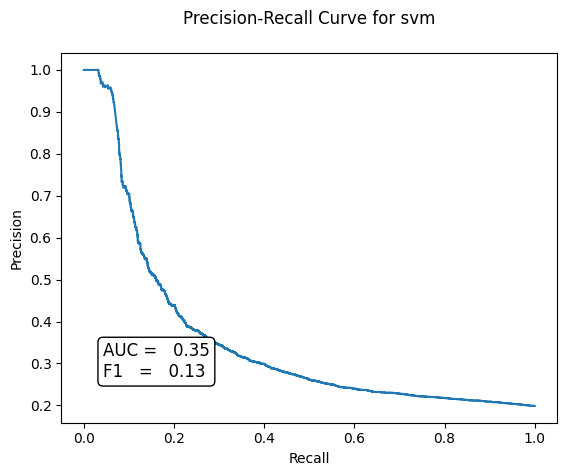

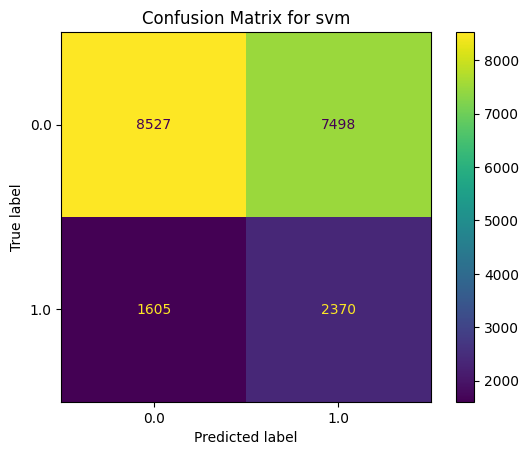

In [14]:
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = svm_model.predict_proba(x_test)[:, 1]
y_pred = svm_model.predict(x_test)
plots.save_precision_recall_curve("svm", "rbf_auto_c1", y_test, y_prob)
plots.save_confusion_matrix("svm", "rbf_auto_c1", y_test, y_pred)